# Prediction with pre-trained CNNs
This notebook contains all the code you need to use a pre-trained OpenSoundscape convolutional neural network model (CNN) to make predictions on your own data. Before attempting this tutorial, install OpenSoundscape by following the instructions on the OpenSoundscape website, [opensoundscape.org](http://opensoundscape.org/). More detailed tutorials about data preprocessing, training CNNs, and customizing prediction methods can also be found on this site.



## Load required packages

The `cnn` module provides a function `load_model` to load saved opensoundscape models

In [1]:
from opensoundscape.torch.models.cnn import load_model
import opensoundscape

load some additional packages and perform some setup for the Jupyter notebook.

In [2]:
# Other utilities and packages
import torch
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob
import subprocess

In [3]:
#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

For this example, let's create an untrained model and save it. This 2-class model is not actually good at recognizing any particular species, but it's useful for illustrating how prediction works. 


In [4]:
from opensoundscape.torch.models.cnn import CNN
CNN('resnet18',['classA','classB'],5.0).save('./temp.model')

### Load a saved model

load the model object using the `load_model` function imported above

(if the model was created with an older version of opensoundscape, see instructions below)

In [5]:
model = load_model('./temp.model')

### Choose audio files for prediction

Create a list of audio files to predict on. They can be of any length. Consider using `glob` to find many files at once.

For this example, let's download a 1-minute audio clip from the Kitzes Lab box to use as an example.

In [6]:
subprocess.run(['curl',
               'https://pitt.box.com/shared/static/z73eked7quh1t2pp93axzrrpq6wwydx0.wav', 
                '-L', '-o', '1min_audio.wav'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0      7      0 --:--:-- --:--:-- --:--:--     7
100 3750k  100 3750k    0     0  1631k      0  0:00:02  0:00:02 --:--:-- 3387k


CompletedProcess(args=['curl', 'https://pitt.box.com/shared/static/z73eked7quh1t2pp93axzrrpq6wwydx0.wav', '-L', '-o', '1min_audio.wav'], returncode=0)

use glob to create a list of all files matching a pattern in a folder:

In [7]:
from glob import glob 
audio_files = glob('./*.wav') #match all .wav files in the current directory
audio_files

['./1min_audio.wav']

## generate predictions with the model
The model returns a dataframe with a MultiIndex of file, start_time, and end_time. There is one column for each class. 

In [8]:
scores, _, _ = model.predict(audio_files)
scores.head()

[]


classA    classB
file             start_time end_time                    
./1min_audio.wav 0.0        5.0       0.630144  1.316480
                 5.0        10.0      0.732882  1.038780
                 10.0       15.0      1.003285  1.481237
                 15.0       20.0      0.692311  1.274447
                 20.0       25.0      0.444356  1.859362

## Overlapping prediction clips

In [9]:
scores, _, _ = model.predict(audio_files, overlap_fraction=0.5)
scores.head()

[]


classA    classB
file             start_time end_time                    
./1min_audio.wav 0.0        5.0       0.823733  1.446082
                 2.5        7.5       0.905710  1.936355
                 5.0        10.0      0.600305  1.628633
                 7.5        12.5      0.865026  1.123674
                 10.0       15.0      0.766736  1.331878

## Inspect samples generated during prediction

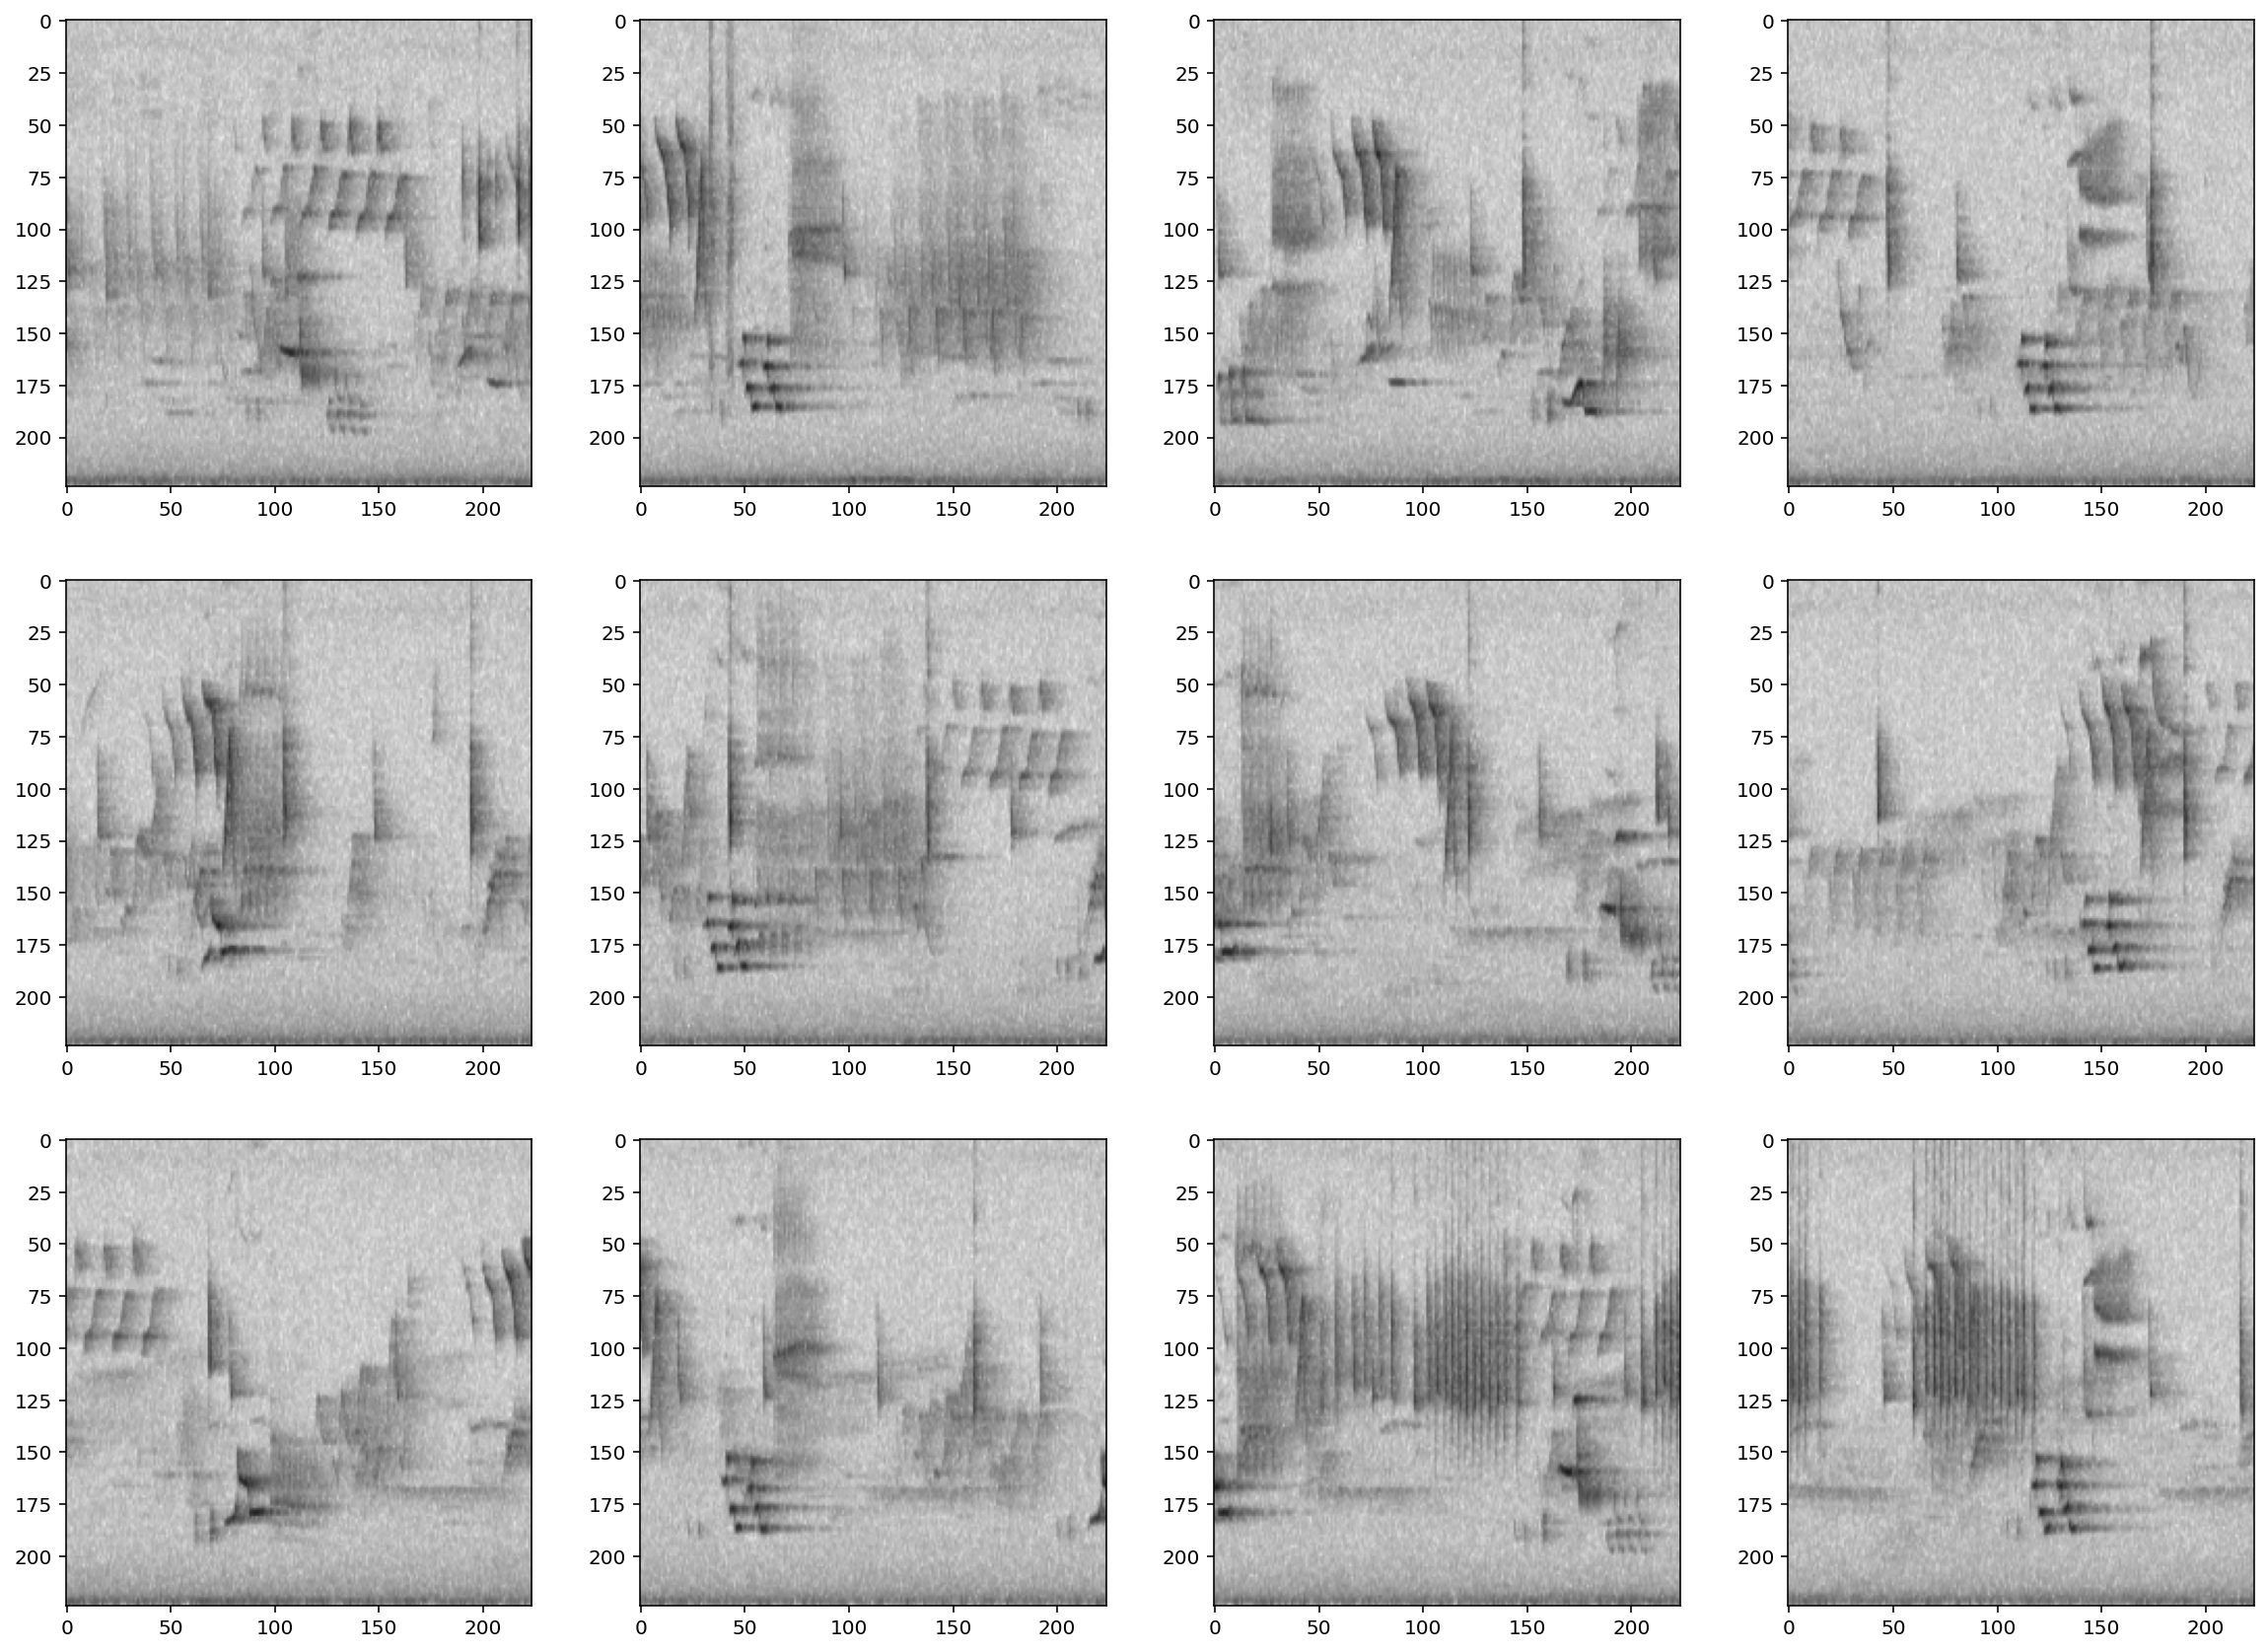

In [10]:
from opensoundscape.preprocess.utils import show_tensor_grid
from opensoundscape.torch.datasets import AudioSplittingDataset

#generate a dataset with the samples we wish to generate and the model's preprocessor
inspection_dataset = AudioSplittingDataset(audio_files, model.preprocessor) 
inspection_dataset.bypass_augmentations = True

samples = [sample['X'] for sample in inspection_dataset]
_ = show_tensor_grid(samples,4)

# Options for prediction

The code above returns the raw predictions of the model without any post-processing (such as a softmax layer or a sigmoid layer). 

For details on how to use the `predict()` function for post-processing of predictions and to generate binary 0/1 predictions of class presence, see the "Basic training and prediction with CNNs" tutorial notebook. But, as a quick example here, let's add a softmax layer to make the prediction scores for both classes sum to 1. We can also use the `binary_preds` argument to generate 0/1 predictions for each sample and class. For presence/absence models, use the option `binary_preds='single_target'`. For multi-class models, think about whether each clip should be labeled with only one class (single target) or whether each clip could contain multiple classes (`binary_preds='multi_target'`)

In [11]:
scores, binary_predictions, _ = model.predict(
    audio_files,
    activation_layer='softmax',
    binary_preds='single_target'
)

[]


As before, the `scores` are continuous variables, but now have been softmaxed:

In [12]:
scores.head()

classA    classB
file             start_time end_time                    
./1min_audio.wav 0.0        5.0       0.410776  0.589224
                 5.0        10.0      0.292443  0.707557
                 10.0       15.0      0.283341  0.716659
                 15.0       20.0      0.289429  0.710571
                 20.0       25.0      0.324280  0.675720

We also have an additional output, the binary 0/1 ("absent" vs "present") predictions generated by the model:

In [13]:
binary_predictions.head()

classA  classB
file             start_time end_time                
./1min_audio.wav 0.0        5.0          0.0     1.0
                 5.0        10.0         0.0     1.0
                 10.0       15.0         0.0     1.0
                 15.0       20.0         0.0     1.0
                 20.0       25.0         0.0     1.0

It is sometimes helpful to look at a histogram of the scores:

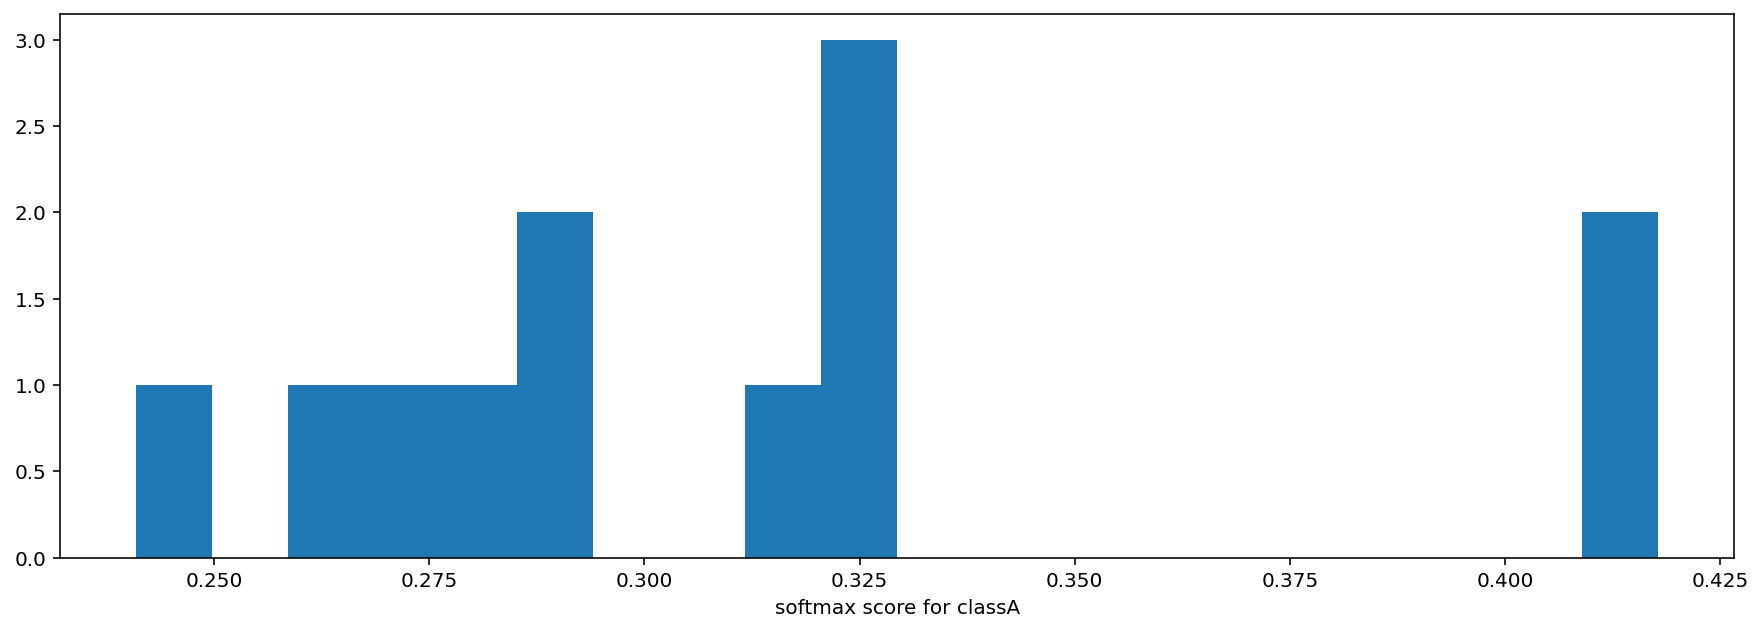

In [14]:
_ = plt.hist(scores['classA'],bins=20)
_ = plt.xlabel('softmax score for classA')

## Using models from older OpenSoundscape versions

### Models from OpenSoundscape 0.4.x and 0.5.x
Models trained and saved with OpenSoundscape versions 0.4.x and 0.5.x need to be loaded in a different way, and require that you know the architecture of the saved model.

For example, one set of our publicly availably [binary models for 500 species](https://pitt.app.box.com/s/3048856qbm9x55yi3zfksa3fide5uuf4) was created with an older version of OpenSoundscape. These models require a little bit of manipulation to load into OpenSoundscape 0.5.x and onward. 

First, let's download one of these models (it's stored in a .tar format) and save it to the same directory as this notebook in a file called `opso_04_model_acanthis-flammea.tar`

In [15]:
subprocess.run(['curl',
               'https://pitt.box.com/shared/static/lglpty35omjhmq6cdz8cfudm43nn2t9f.tar', 
                '-L', '-o', 'opso_04_model_acanthis-flammea.tar'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      7      0 --:--:--  0:00:01 --:--:--     0
100 42.9M  100 42.9M    0     0  9229k      0  0:00:04  0:00:04 --:--:-- 17.1M


CompletedProcess(args=['curl', 'https://pitt.box.com/shared/static/lglpty35omjhmq6cdz8cfudm43nn2t9f.tar', '-L', '-o', 'opso_04_model_acanthis-flammea.tar'], returncode=0)

From the model notes page, we know that this is a single-target model with a resnet18 architecture trained on 5 second files. Let's load the model with `load_outdated_model`. We also need to make sure we use the same preprocessing settings as the original model. In this case, the original model used the same preprocessing settings as the default CNN.preprocessor.

In [16]:
from opensoundscape.torch.models.cnn import load_outdated_model

In [17]:
model = load_outdated_model('./opso_04_model_acanthis-flammea.tar','resnet18',5.0)

mismatched keys:
<All keys matched successfully>


/opt/anaconda3/envs/opso_poetry_py38/lib/python3.8/site-packages/pandas/core/series.py:3247: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  other = Series(other)
/Users/louifh/Dev/opensoundscape/opensoundscape/torch/models/cnn.py:1157: UserWarning: After loading a model, you still need to ensure that your preprocessing (model.preprocessor) matches the settings used to createthe original model.
  warnings.warn(


Again, you may need to modify model.preprocessor to match the settings used to train the model. 

The model is now fully compatible with OpenSoundscape, and can be used as above. For example:

In [18]:
scores, _, _ = model.predict(audio_files)
scores.head()

[]


acanthis-flammea-absent  \
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                      4.663996   
                 5.0        10.0                     3.829890   
                 10.0       15.0                     2.224010   
                 15.0       20.0                     1.843545   
                 20.0       25.0                     2.420115   

                                      acanthis-flammea-present  
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                      -4.259652  
                 5.0        10.0                     -3.438777  
                 10.0       15.0                     -1.916160  
                 15.0       20.0                     -2.184236  
                 20.0       25.0                     -2.016437

if we save the model using `model.save(path)`, we can re-load the full model object later using `load_model()` rather than repeating the procedure above. 

### Loading models from OpenSoundscape 0.6.x

If you saved a model with OpenSoundscape 0.6.x and want to use it in 0.7.0 or above, you will need to re-load the model using the original OpenSoundscape version that it was created with and save the model's weights explicitly:

```
#OpenSoundscape version 0.6.x
model = load_model('/path/to/saved.model')

dict_to_save = {
    'network_state_dict':model.network.state_dict(),
    'classes': model.classes,
    '
}
torch.save(dict_to_save, '/path/to/model_dict.pt')
```

Then, you will be able to create a new model object in OpenSoundscape 0.7.0 and load the weights from the state dict as demonstrated above. Make sure to specify the correct architecture and sample duration when you create the CNN object. 
```
#newer OpenSoundscape version
model_dict = torch.load('/path/to/model_dict.pt')
classes = model_dict["classes"]

architecture = 'resnet18' #match this with the original model!

sample_duration = 5.0 #match this with the original model!

model = CNN('resnet18',classes,sample_duration)
model.network.load_state_dict(model_dict['network_state_dict'])

#save the model object so that we can simply reload it with load_model() in the future:
model.save('/path/to/saved_full_object.model')

# Next time, we can just load the full model object directly:
from opensoundscape.torch.models.cnn import load_model
model = load_model('/path/to/saved_full_object.model')
```

OpenSoundscape model objects include helper functions .save_weights() and .load_weights() which allow you to save and load platform/class independent dictionaries for increased flexibility. The weights saved and loaded by these functions are simply a dictionary of keys and numeric values, so they don't depend on the existence of particular classes in the code base. We recommend saving both the full model object (`.save()`) and the raw weights (`.save_weights()`) for models you plan to use in the future. 

### Clean up: delete model objects

In [19]:
from pathlib import Path
for p in Path('.').glob('*.model'):
    p.unlink()
for p in Path('.').glob('*.tar'):
    p.unlink()
Path('1min_audio.wav').unlink()